In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from new_train import train_nis
from new_train import train_nisp_rnis
from nis_net import NISNet
from nis_net import NISPNet
from nis_net import RNISNet
from datetime import datetime
from new_sir import SIRModel
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Generate data

In [4]:

sigma = 0.03
rho = -0.5
steps = 7
dt = 0.01

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
sir_train = SIRModel(size_list=[8000], beta=1, gamma=0.5, steps=7, dt=dt, interval=1, sigma=sigma, rho=rho)
train_data = [torch.FloatTensor(sir_train.sir_input).to(device), torch.FloatTensor(sir_train.sir_output).to(device)]
sir_test = SIRModel(size_list=[1000], beta=1, gamma=0.5, steps=7, dt=dt, interval=1, sigma=sigma, rho=rho)
test_data = [torch.FloatTensor(sir_test.sir_input).to(device), torch.FloatTensor(sir_test.sir_output).to(device)]



# Trian

In [7]:
experiments = 5
T_total = 30001
clip = 300
sz = 4
scale = 2
hidden_units = 64
batch_size = 128
clip=500
eis_nis_e = np.zeros([experiments, T_total//clip+1])
losses_nis_e = np.zeros([experiments, T_total//clip+1])
MAEs_mstep_nis_e = np.zeros([experiments, T_total//clip+1])
eis_nisp_e = np.zeros([experiments, T_total//clip+1])
losses_nisp_e = np.zeros([experiments, T_total//clip+1])
MAEs_mstep_nisp_e = np.zeros([experiments, T_total//clip+1])
eis_rnis_e = np.zeros([experiments, T_total//clip+1])
losses_rnis_e = np.zeros([experiments, T_total//clip+1])
MAEs_mstep_rnis_e = np.zeros([experiments, T_total//clip+1])

# Train RNIS

In [ ]:
# nis+

for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    net_rnis = RNISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=32,
                        is_normalized=True)
    trainer = train_nisp_rnis(net=net_rnis, data=train_data, data_test=test_data, device=device)
    trainer.training(T1=3000, T_all=T_total, mae2_w=1, batch_size=batch_size, clip=clip)
    eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis = trainer.return_log()

    eis_rnis_e[e,:] = eis_rnis
    losses_rnis_e[e,:] = losses_rnis
    MAEs_mstep_rnis_e[e,:] = MAEs_mstep_rnis

check point------step-> 10:39:53.036339; lasting 0:02:09.671254 seconds
Epoch: 0
Train loss: 0.0011
Test loss: 0.4890
dEI: 0.3398
term1: -0.6118
term2: 1.2913
------------------------------------------------------------------------------------------------------------------------
check point------step-> 10:40:11.310395; lasting 0:00:18.274056 seconds
Epoch: 500
Train loss: 0.2624
Test loss: 0.1063
dEI: 1.2397
term1: 0.8019
term2: 1.6774
------------------------------------------------------------------------------------------------------------------------
check point------step-> 10:40:29.879802; lasting 0:00:18.569407 seconds
Epoch: 1000
Train loss: 0.0560
Test loss: 0.0392
dEI: 1.8993
term1: 2.1839
term2: 1.6146
------------------------------------------------------------------------------------------------------------------------
check point------step-> 10:40:48.482116; lasting 0:00:18.602314 seconds
Epoch: 1500
Train loss: 0.0363
Test loss: 0.0347
dEI: 2.0202
term1: 2.4558
term2: 1.5

# Train NIS

In [ ]:
# nis
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    net_nis = NISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, is_normalized=True)
    trainer = train_nis(net=net_nis, data=train_data, data_test=test_data, device=device)
    trainer.training(T_all=T_total, batch_size=batch_size, clip=clip)
    eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis = trainer.return_log()
    eis_nis_e[e,:] = eis_nis
    losses_nis_e[e,:] = losses_nis
    MAEs_mstep_nis_e[e,:] = MAEs_mstep_nis

# Train NIS+

In [ ]:
# nis+
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    net_nisp = NISPNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=hidden_units,
                        is_normalized=True)
    trainer = train_nisp_rnis(net=net_nisp, data=train_data, data_test=test_data, device=device)
    trainer.training(T1=3000, T_all=T_total, mae2_w=1, batch_size=batch_size, clip=clip)
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp = trainer.return_log()
    eis_nisp_e[e,:] = eis_nisp
    losses_nisp_e[e,:] = losses_nisp
    MAEs_mstep_nisp_e[e,:] = MAEs_mstep_nisp

# Results

In [ ]:
np.save('results/eis_nis_e.npy', eis_nis_e)
np.save('results/losses_nis_e.npy', losses_nis_e)
np.save('results/MAEs_mstep_nis_e.npy', MAEs_mstep_nis_e)
np.save('results/eis_nisp_e.npy', eis_nisp_e)
np.save('results/losses_nisp_e.npy', losses_nisp_e)
np.save('results/MAEs_mstep_nisp_e.npy', MAEs_mstep_nisp_e)
np.save('results/eis_rnis_e.npy', eis_rnis_e)
np.save('results/losses_rnis_e.npy', losses_rnis_e)
np.save('results/MAEs_mstep_rnis_e.npy', MAEs_mstep_rnis_e)

In [13]:
# 定义一个字典来存储文件名和对应的变量名
file_dict = {
    'eis_nis_e': 'results/eis_nis_e.npy',
    'losses_nis_e': 'results/losses_nis_e.npy',
    'MAEs_mstep_nis_e': 'results/MAEs_mstep_nis_e.npy',
    'eis_nisp_e': 'results/eis_nisp_e.npy',
    'losses_nisp_e': 'results/losses_nisp_e.npy',
    'MAEs_mstep_nisp_e': 'results/MAEs_mstep_nisp_e.npy',
    'eis_rnis_e': 'results/eis_rnis_e.npy',
    'losses_rnis_e': 'results/losses_rnis_e.npy',
    'MAEs_mstep_rnis_e': 'results/MAEs_mstep_rnis_e.npy'
}

# 创建一个字典来存储加载的数据
data_dict = {}

# 加载每个文件并将数据存储在字典中
for var_name, file_path in file_dict.items():
    data_dict[var_name] = np.load(file_path)

# 打印每个变量的数据和形状
for var_name, data in data_dict.items():
    print(f"{var_name} shape: {data.shape}")

eis_nis_e shape: (5, 81)
losses_nis_e shape: (5, 81)
MAEs_mstep_nis_e shape: (5, 81)
eis_nisp_e shape: (5, 81)
losses_nisp_e shape: (5, 81)
MAEs_mstep_nisp_e shape: (5, 81)
eis_rnis_e shape: (5, 81)
losses_rnis_e shape: (5, 81)
MAEs_mstep_rnis_e shape: (5, 81)


ValueError: x and y must have same first dimension, but have shapes (61,) and (81,)

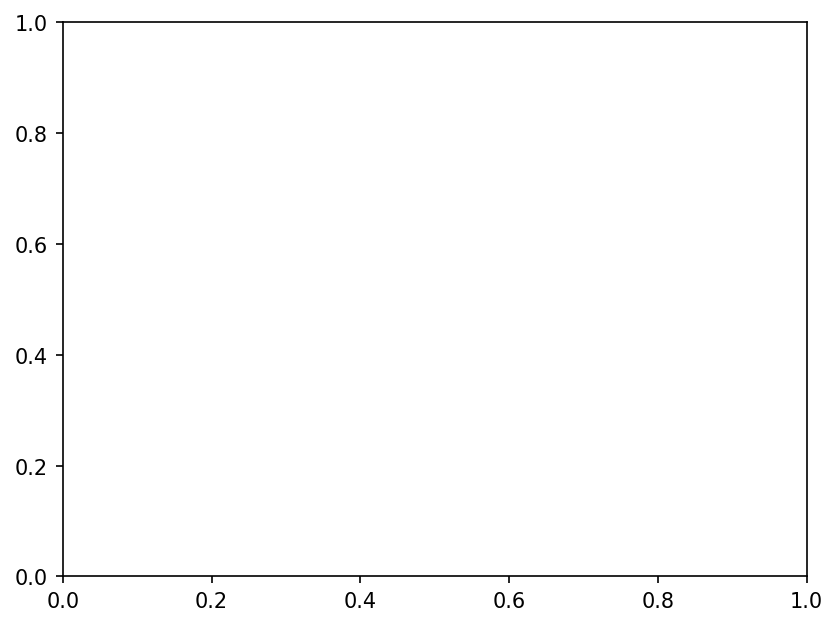

In [14]:
plt.figure(dpi=150)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
timesteps = np.arange(len(eis_nis)) * clip
means_nis = np.mean(data_dict['eis_nis_e'],axis=0)
stds_nis = np.std(data_dict['eis_nis_e'],axis=0)
means_nisp = np.mean(data_dict['eis_nisp_e'],axis=0)
stds_nisp = np.std(data_dict['eis_nisp_e'],axis=0)
means_rnis = np.mean(data_dict['eis_rnis_e'],axis=0)
stds_rnis = np.std(data_dict['eis_rnis_e'],axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.plot(timesteps, means_rnis, label='RNIS part sample',color=color_label[3])
plt.fill_between(timesteps, means_rnis-stds_rnis, means_rnis+stds_rnis,alpha=0.25,color=color_label[3])
plt.legend()
plt.xlabel("epoch")
plt.ylabel(r'$\mathcal{J}$')
plt.show()

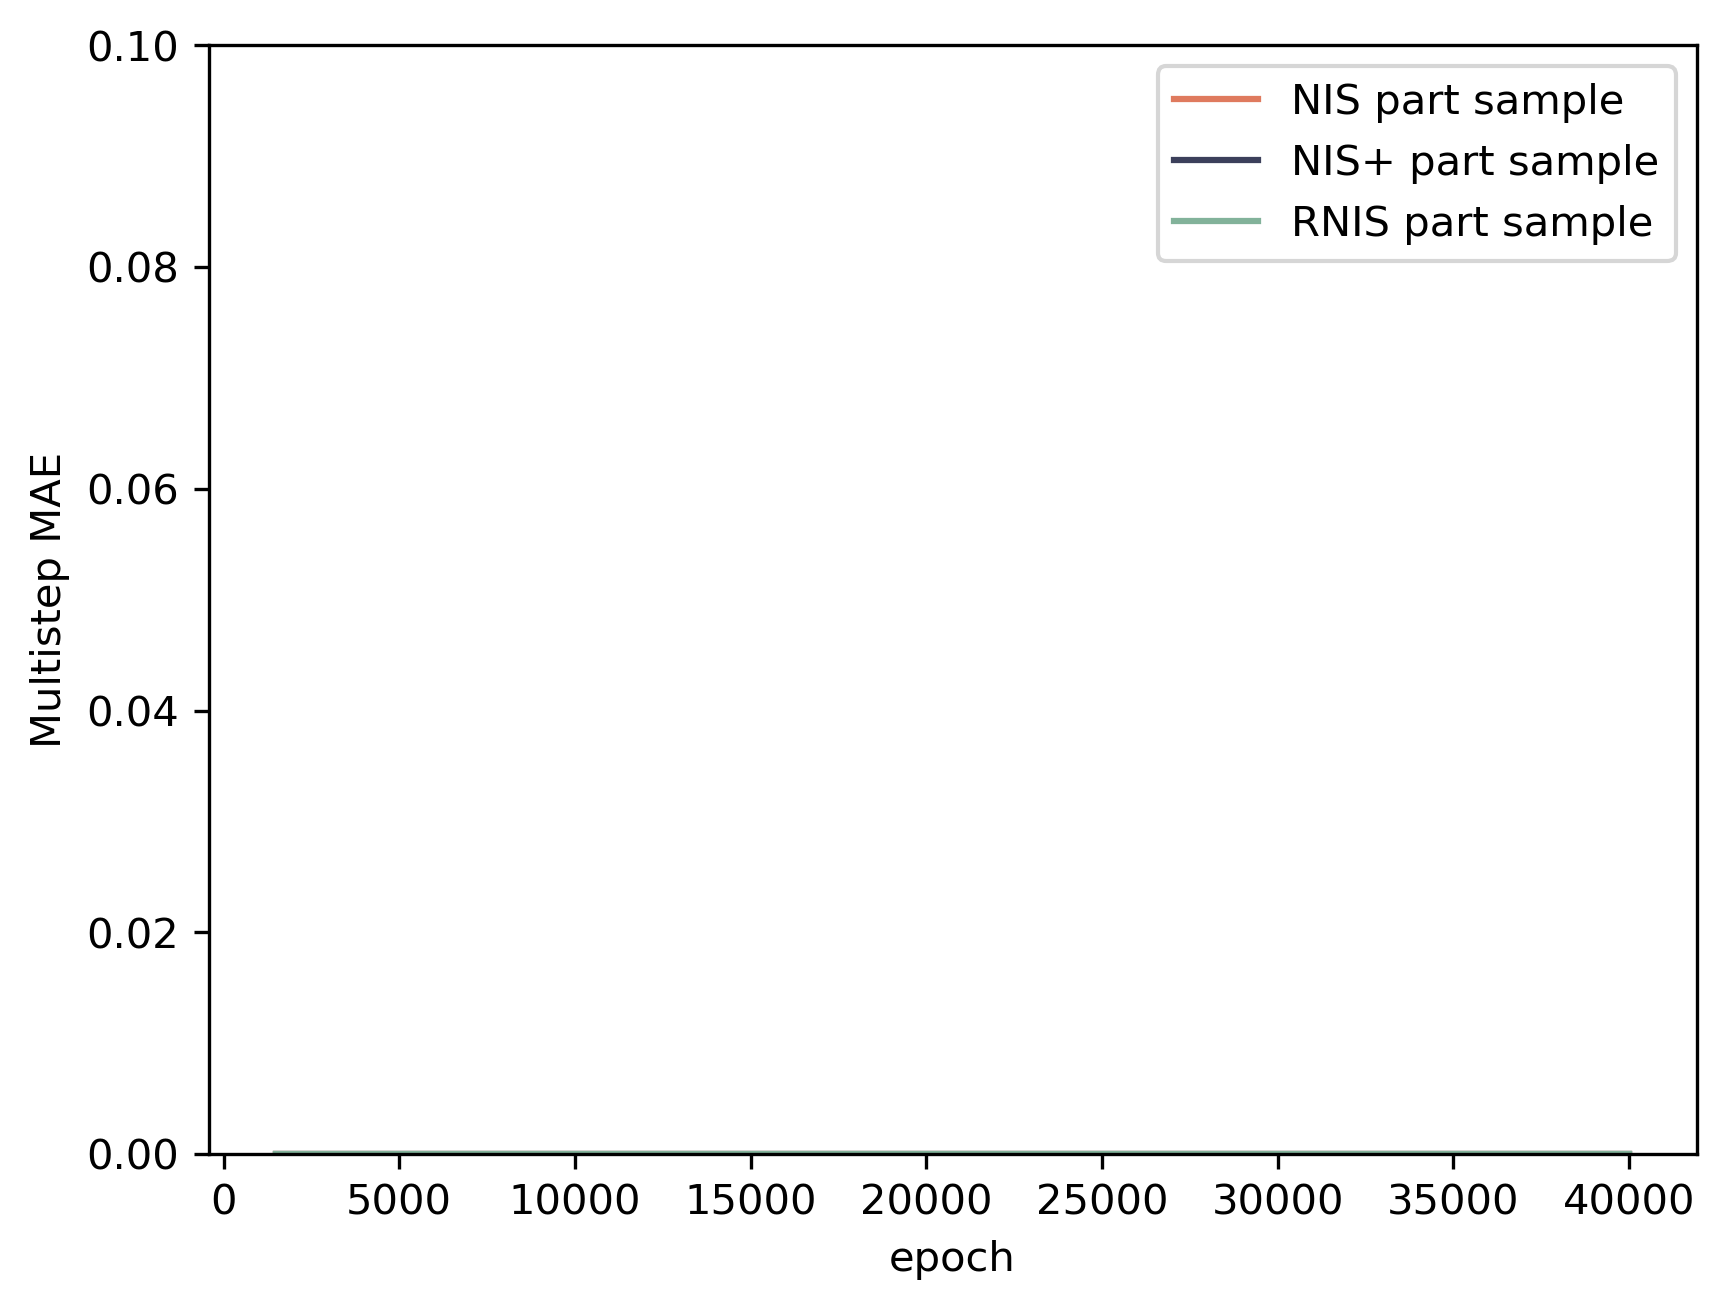

In [10]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
lens=len(MAEs_mstep_nis_e[0,3:])
timesteps = np.arange(len(MAEs_mstep_nis_e[0,:]))[3:]*500
compare1=np.cumsum(data_dict['MAEs_mstep_nis_e'][:,3:],1)/np.linspace(1, lens, lens)
compare2=np.cumsum(data_dict['MAEs_mstep_nisp_e'][:,3:],1)/np.linspace(1, lens, lens)
compare3=np.cumsum(data_dict['MAEs_mstep_rnis_e'][:,3:],1)/np.linspace(1, lens, lens)
means_nis = np.mean(compare1,axis=0)
stds_nis = np.std(compare1,axis=0)
means_nisp = np.mean(compare2,axis=0)
stds_nisp = np.std(compare2,axis=0)
means_rnis = np.mean(compare3,axis=0)
stds_rnis = np.std(compare3,axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.plot(timesteps, means_rnis, label='RNIS part sample',color=color_label[3])
plt.fill_between(timesteps, means_rnis-stds_rnis, means_rnis+stds_rnis,alpha=0.25,color=color_label[3])
plt.legend()
plt.xlabel("epoch")
plt.ylabel('Multistep MAE')
plt.ylim([0,0.1])
plt.show()